# Homework 1

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

This homework relies on the data file, `treasury_quotes_2023-07-26`.

#### Nominal Securities
The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `ITYPE` of 11 or 12, as these indicate a TIPS Note or TIPS bond.


#### More Info
Find more info about many of the fields in the data set at the following link,

https://www.crsp.org/products/documentation/treasno-properties

Find the complete manual for the CRSP Treasury data at the following link,

https://www.crsp.org/files/treasury_guide_0.pdf

In [1]:
# PACKAGES
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy.optimize import newton
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from pyprojroot import here
import os 
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# SETTINGS
pd.set_option('display.float_format', '{:.4f}'.format) # Limiting floats output to 3 decimal points

# Set working directory
os.chdir("/Users/charleston/Downloads")
 
# DATE
quote_date = '2023-07-26'

# DATA
treasury_quotes = pd.read_excel(here(f"./Downloads/treasury_quotes_{quote_date}.xlsx"), sheet_name="quotes", index_col=0)
treasury_quotes.columns = treasury_quotes.columns.str.upper()
treasury_quotes.sort_values('TMATDT',inplace=True)

# Remove TIPS
treasury_quotes.query('ITYPE != 11 and ITYPE != 12', inplace=True)


In [2]:
t_check = treasury_quotes['CALDT'].values[0]
if treasury_quotes['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None


# Problem 1: Explore the Data

## 1 Maturity

For each issue, calculate its time-to-maturity, quoted in number of years, based on the issue and maturity dates. Assume a year has exactly 365.25 days.

Report the summary statistics of these time-to-maturities. Consider using `.describe()`.

In [3]:
# Create most relevant variables in the most common used format
metrics = treasury_quotes.copy()[['TDATDT','TMATDT','TCOUPRT','TDYLD','TDDURATN','TDPUBOUT']]
metrics.columns = ['issue date','maturity date','coupon rate','TDYLD','duration','outstanding']
metrics['TDYLD'] *= 365.25 # To convert it into yearly yields to maturity
metrics['duration'] /= 365.25 # Divided to express it in years (it is initially daily)
metrics['outstanding'] *= 1e6 # To convert it into dollars (it is initially in millions)
metrics['dirty_price'] = (treasury_quotes['TDBID'] + treasury_quotes['TDASK'])/2 + treasury_quotes['TDACCINT']
metrics['ask-bid'] = treasury_quotes['TDASK'] - treasury_quotes['TDBID']
metrics['ttm_today'] = (metrics['maturity date'] - t_current).dt.days/365.25
metrics['ttm_issue'] = (metrics['maturity date'] - metrics['issue date']).dt.days/365.25
#metrics['maturity'] = get_maturity_delta(metrics['maturity date'], t_current)
#metrics['next cashflow date'] = (calc_cashflows(treasury_quotes) != 0).idxmax(1)

In [4]:
metrics[['ttm_today', 'ttm_issue']].describe()

,ttm_today,ttm_issue
count,386.0000,386.0000
mean,6.2607,10.6094
std,8.0040,10.5549
min,0.0027,0.3231
25%,0.9001,3.0007
50%,2.8255,7.0007
75%,6.5496,10.0014
max,29.6372,30.5051


## 2 Prices 

Calculate the "dirty" price for each bond issue as
$$\text{price} = \frac{1}{2}(\text{TDBID} + \text{TDASK}) + \text{TDACCINT}$$
Namely, you are taking the midpoint of the bid and ask prices, and then you add the accrued interest.

We will discuss this adjustment for accrued interest later. For now, simply adjust as described in the formula.

## 3 YTM

Write a function to calculate the yield-to-maturity for each issue. You will need to use a nonlinear solver to solve for the YTM.

Create a dataframe with the following columns:


| maturity | price | coupon rate | ytm | TDYLD | bid-ask |
|----------|-------|-------------|-----|----------|---------|

where 
* `maturity` refers to the time-to-maturity
* `TDYLD` is the YTM calculated by the data provider

Use `describe()` in pandas to to show descriptive statistics for this dataframe.

In [ ]:
quote_data = treasury_quotes.copy()
import pdb
CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())
for i in quote_data.index:
        pdb.set_trace()
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


> /var/folders/8m/h9p4w9xx385dnwz_x2453dyc0000gn/T/ipykernel_30175/2642291763.py(6)<module>()
      4 for i in quote_data.index:
      5         pdb.set_trace()
----> 6         coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])
      7 
      8         if coupon_dates is not None:



In [12]:
from scipy.optimize import fsolve

def pv(rate, cashflows, maturities,freq=1):
    price = sum([cfi/(1+rate/freq)**(maturities[i]*freq) for i, cfi in enumerate(cashflows)])
    return price

def calc_cashflows(quote_data, filter_maturity_dates=False):
    
    CF = pd.DataFrame(data=0, index=quote_data.index, columns=quote_data['TMATDT'].unique())

    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100


    CF = CF.fillna(0).sort_index(axis=1)
    CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

    if filter_maturity_dates:
        CF = filter_treasury_cashflows(CF, filter_maturity_dates=True)
        
    return CF

def get_coupon_dates(quote_date,maturity_date):

    if isinstance(quote_date,str):
        quote_date = datetime.datetime.strptime(quote_date,'%Y-%m-%d')
        
    if isinstance(maturity_date,str):
        maturity_date = datetime.datetime.strptime(maturity_date,'%Y-%m-%d')
    
    # divide by 180 just to be safe
    temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
    # filter out if one date too many
    temp = pd.DataFrame(data=temp[temp > quote_date])

    out = temp[0]
    return out


def compound_rate(intrate,compound_input,compound_output):
    
#    outrate = intrate[['maturity']]
    
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

In [6]:
CF = calc_cashflows(treasury_quotes)
# First part is the average of the ask and bid prices, second part is the accrued interest
# The loc is to keep only the observations that we have in the cashflows
px = (treasury_quotes[['TDASK', 'TDBID']].mean(axis=1) + treasury_quotes['TDACCINT']).loc[CF.index]

maturity_grid = pd.Series((CF.columns.values - t_current) / pd.Timedelta('365.25 days'), index=CF.columns)

ytm = pd.DataFrame(index=px.index,columns=['annual','semiannual','daily','continuous'],dtype=float)

for idbond in px.index:
    pv_wrapper = lambda y: px.loc[idbond] - pv(y,CF.loc[idbond,:].values, maturity_grid.values,freq=2)
    ytm.loc[idbond,'semiannual'] = fsolve(pv_wrapper,.01)

ytm['annual'] = compound_rate(ytm['semiannual'],2,1)
ytm['daily'] = compound_rate(ytm['semiannual'],2,365)
ytm['continuous'] = compound_rate(ytm['semiannual'],2,None)
ytm


,annual,semiannual,daily,continuous
kytreasno,,,,
207997,0.0520,0.0514,0.0507,0.0507
207231,0.0278,0.0276,0.0274,0.0274
207742,0.0332,0.0329,0.0326,0.0326
206998,0.0447,0.0442,0.0437,0.0437
208025,0.0531,0.0524,0.0518,0.0518
...,...,...,...,...
207891,0.0399,0.0395,0.0391,0.0391
207934,0.0399,0.0395,0.0391,0.0391
207977,0.0397,0.0393,0.0389,0.0389


In [7]:
bond_metrics = metrics.join(ytm)[['ttm_today', 'dirty_price', 'coupon rate', 'annual','semiannual','daily','continuous', 'TDYLD', 'ask-bid']]
bond_metrics.describe()

,ttm_today,dirty_price,coupon rate,annual,semiannual,daily,continuous,TDYLD,ask-bid
count,386.0000,386.0000,386.0000,386.0000,386.0000,386.0000,386.0000,386.0000,386.0000
mean,6.2607,94.2958,2.1826,0.0470,0.0465,0.0459,0.0459,0.0459,0.0366
std,8.0040,8.8615,1.6342,0.0059,0.0058,0.0057,0.0057,0.0056,0.0184
min,0.0027,55.5180,0.0000,0.0278,0.0276,0.0274,0.0274,0.0274,0.0000
25%,0.9001,90.4425,0.7500,0.0418,0.0413,0.0409,0.0409,0.0409,0.0312
50%,2.8255,96.7252,2.2500,0.0456,0.0451,0.0446,0.0446,0.0444,0.0312
75%,6.5496,99.1635,3.1250,0.0533,0.0526,0.0519,0.0519,0.0519,0.0469
max,29.6372,114.6213,7.6250,0.0618,0.0609,0.0600,0.0600,0.0542,0.0938


## 4 Plots

Create scatter plots of...
* maturity versus price for all issues.
* maturity versus YTM for all issues.

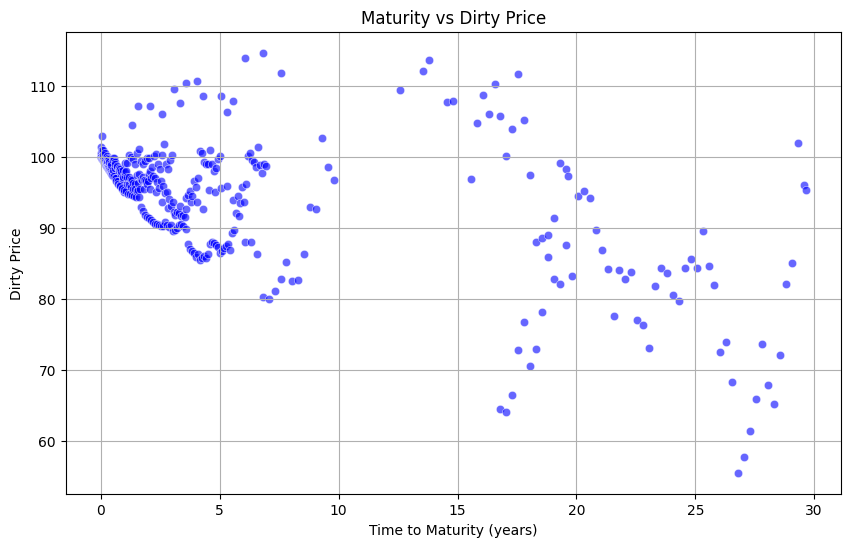

In [8]:
plt.figure(figsize=(10,6))
plt.scatter(metrics['ttm_today'], metrics['dirty_price'], color='blue', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('Maturity vs Dirty Price')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Dirty Price')
plt.grid(True)
plt.show()

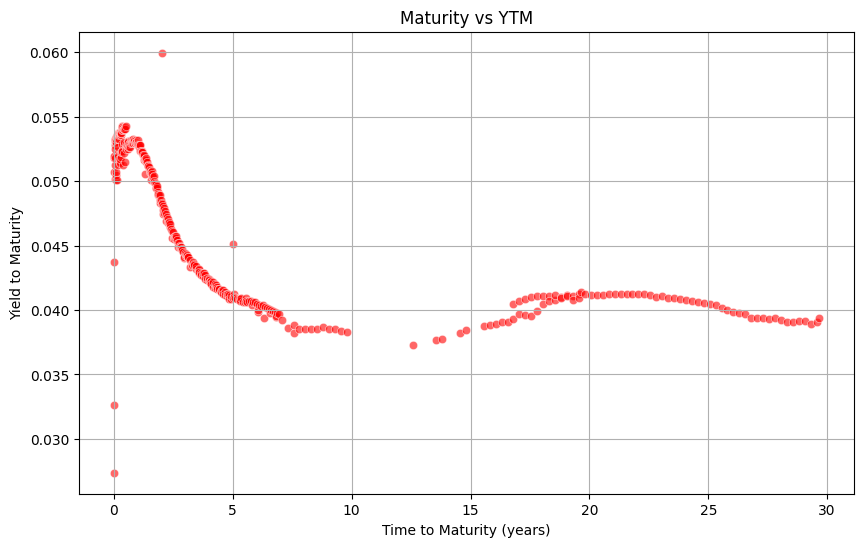

In [9]:
plt.figure(figsize=(10,6))
plt.scatter(metrics['ttm_today'], ytm['continuous'], color='red', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title('Maturity vs YTM')
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Yield to Maturity')
plt.grid(True)
plt.show()

## 5 Bad Data?

Find the issues where `TDYLD` is `NaN`. Display these rows from your table above. How many issues (rows) are effected?

What do you see in the other metrics for these issues that suggests that the price is bad?

In [10]:
bond_metrics[bond_metrics['TDYLD'].isnull()]

,ttm_today,dirty_price,coupon rate,annual,semiannual,daily,continuous,TDYLD,ask-bid
kytreasno,,,,,,,,,


Answer
- We do not have NaN in the variable TDYLD

***

# Problem 2: Extract the Discount Curve

## 1 Map Cashflows

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

You will need to make a few modeling choices to do this...
* eliminate any treasury that does not report `TDYTM` or that reports a negative number for `TDYTM`.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [11]:
display(CF)
prices = metrics['dirty_price'][CF.index]

,2023-07-27,2023-07-31,2023-08-01,2023-08-03,2023-08-08,2023-08-10,2023-08-15,2023-08-17,2023-08-22,2023-08-24,...,2051-09-15,2051-11-15,2052-02-15,2052-03-15,2052-05-15,2052-08-15,2052-09-15,2052-11-15,2053-02-15,2053-03-15
kytreasno,,,,,,,,,,,,,,,,,,,,,
207997,100,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207231,0,101.3750,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
207742,0,100.0625,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
206998,0,100.6250,0,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
208025,0,0.0000,100,0,0,0,0.0000,0,0,0,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207891,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,1.4375,0.0000,0.0000,101.4375,0.0000,0.0000,0,0.0000,0.0000
207934,0,0.0000,0,0,0,0,1.5000,0,0,0,...,0.0000,0.0000,1.5000,0.0000,0.0000,101.5000,0.0000,0,0.0000,0.0000
207977,0,0.0000,0,0,0,0,0.0000,0,0,0,...,0.0000,2.0000,0.0000,0.0000,2.0000,0.0000,0.0000,102,0.0000,0.0000


In [12]:
print(f'The date with the most cashflow is {CF.sum().idxmax()}, with cashflows adding to {CF.sum().max()}')

The date with the most cashflow is 2023-08-15 00:00:00, with cashflows adding to 517.6875


In [13]:
print(f'The date with the most issues paying a cashflow is {CF.astype(bool).sum(axis=0).idxmax()}, with {CF.astype(bool).sum(axis=0).max()} issues paying a cashflow')

The date with the most issues paying a cashflow is 2023-08-15 00:00:00, with 76 issues paying a cashflow


## 2 Bootstrap

Bootstrap the discount factors.

Starting with $C$ from the previous problem, further filter to create a subset of Treasury issues cashflow matrix $\tilde{C}$, such that each column has one, and only one, maturity. Also, each issue (row) has its face value payment in one of the columns.

The three step procedure below might be useful.

1. For dates with multiple bonds maturing, keep only that with the smallest bid-ask. If there are still multiple bonds maturing on the date, keep only that with the smallest coupon.

2. Only keep the first $L$ columns of the cashflow matrix, such that every column has a bond maturing on that date.

3. Eliminate any bonds, (rows,) that had maturity beyond column $L$.

This should produce the cashflow matrix, $\tilde{C}$.

**Report 5 head and tail rows of $\tilde{C}$.**

Solve the system of equations
$$\textbf{p} = \tilde{\textbf{C}}\, \textbf{z}_{\text{bootstrap}}$$

**Plot the estimated discount factors, $\textbf{z}$, against time-to-maturity.**

In [20]:
def get_maturity_delta(t_maturity,t_current):

    maturity_delta = (t_maturity - t_current) / pd.Timedelta('365.25 days')
    
    return maturity_delta

def estimate_rate_curve(model,CF,t_current,prices,x0=None):

    if model is bootstrap:
        params = estimate_curve_ols(CF,prices,interpolate=False)
        
        CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current=t_current).values
    
        params_optimized = [CF_intervals,params]

    else:
        if x0 is None:
            if model is nelson_siegel:
                x0 = np.ones(4)/10
            elif model is nelson_siegel_extended:
                x0 = np.ones(6)
            else:
                x0 = 1        

        mod = minimize(pricing_errors, x0, args=(CF, t_current, model, prices))
        params_optimized = mod.x

    return params_optimized

def estimate_curve_ols(CF,prices,interpolate=False):

    if isinstance(prices,pd.DataFrame) or isinstance(prices,pd.Series):
        prices = prices[CF.index].values
    
    mod = LinearRegression(fit_intercept=False).fit(CF.values,prices)

    if interpolate:
        matgrid = get_maturity_delta(CF.columns,CF.columns.min())

        dts_valid = np.logical_and(mod.coef_<1.25, mod.coef_>0)

        xold = matgrid[dts_valid]
        xnew = matgrid
        yold = mod.coef_[dts_valid]

        f = interpolate.interp1d(xold, yold, bounds_error=False, fill_value='extrapolate')    
        discounts = f(xnew)

    else:
        discounts = mod.coef_    
        
    return discounts

def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

def bootstrap(params,maturity):
    estimated_maturities = params[0]
    betas = params[1]
    estimated_rates = discount_to_intrate(betas,estimated_maturities)
    
    f = interpolate.interp1d(estimated_maturities, estimated_rates, bounds_error=False, fill_value='extrapolate')
    
    rate = f(maturity)

    return rate

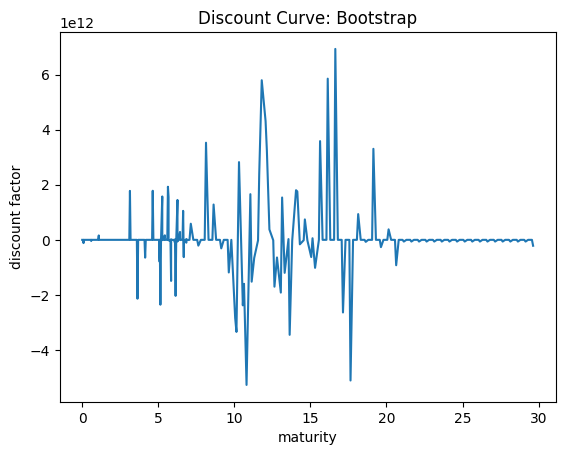

In [25]:
MODEL = bootstrap

prices = metrics['dirty_price'][CF.index]
params_boot = estimate_rate_curve(MODEL,CF,t_current,prices)

plt.plot(params_boot[0],params_boot[1])
plt.xlabel('maturity')
plt.ylabel('discount factor')
plt.title('Discount Curve: Bootstrap')
plt.show()

## 3. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. (You might do something similar to the three-step procedure of the bootstrap, but skip step #1.) Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

**Plot the discount factors against maturities.**

## 4 Factors and Rates

Convert $\textbf{z}_{\text{bootstrap}}$ to a set of 
* continuous discount rates
* semiannually compounded discount rates

Do the same for $\textbf{z}_{\text{ols}}$.

Plot the **continuous** discount rates generated via bootstrap and via OLS against time-to-maturity.

Plot the **semiannually compounded** discount rates generated via bootstrap and via OLS against time-to-maturity.

***

# Problem 3: Nelson-Siegel Curve

Use the Nelson-Siegel curve to model the discount rates. 

Fit them via minimizing the sum of squared errors for the prices imputed by the model versus the quoted prices. 

Consider using `minimize` from `scipy.optimize`.

* Estimate the model three times, using $\textbf{C}$, $\tilde{\textbf{C}}$, $\hat{\textbf{C}}$.

* Plot the estimated discount factors, $\textbf{z}_{\text{ns}}$ against time-to-maturity.

* Also plot the associated continuously-compounded discount rates.